In [3]:
from pandas_datareader import data as pdr
# pip install pandas-datareader
import quandl
# pip install quandl
from googlefinance import getQuotes
# pip install googlefinance
import json

In [4]:
# Data
StockName = 'PTT.BK'
startDate = '2003-1-1'
endDate = '2021-1-1'

In [5]:
def QueryStockIndex(name, startDate, endDate):
    data = pdr.get_data_yahoo(name, start=startDate, end=endDate)
    return data

In [6]:
stock = QueryStockIndex(StockName, startDate, endDate)
print(stock)

              High     Low    Open   Close      Volume  Adj Close
Date                                                             
2003-01-01   4.225   4.225   4.225   4.225         0.0   2.076413
2003-01-02   4.300   4.225   4.225   4.250  18449000.0   2.088699
2003-01-03   4.275   4.225   4.250   4.225  15724000.0   2.076413
2003-01-06   4.250   4.225   4.250   4.250  11980000.0   2.088699
2003-01-07   4.275   4.250   4.250   4.275  22059000.0   2.100986
...            ...     ...     ...     ...         ...        ...
2020-12-24  41.500  40.750  40.750  41.250  45405500.0  41.250000
2020-12-25  42.250  41.250  41.250  42.000  32414000.0  42.000000
2020-12-28  42.750  41.000  42.250  41.000  60698100.0  41.000000
2020-12-29  42.500  41.000  41.250  42.500  41046600.0  42.500000
2020-12-30  43.250  42.250  43.250  42.500  67293300.0  42.500000

[4450 rows x 6 columns]


In [7]:
def QueryOilPrice(startDate, endDate):
    OilPrice = quandl.get("OPEC/ORB", start_date=startDate, end_date=endDate)
    return OilPrice

In [8]:
OPEC = QueryOilPrice(startDate, endDate)
print(OPEC)

            Value
Date             
2003-01-02  30.05
2003-01-03  30.83
2003-01-06  30.71
2003-01-07  29.72
2003-01-08  28.86
...           ...
2020-12-24  50.31
2020-12-28  50.10
2020-12-29  50.16
2020-12-30  50.22
2020-12-31  50.24

[4643 rows x 1 columns]


In [9]:
# write stock data to list
indexStock = []
dataStock = []
closeStock = []
for index, row in stock.iterrows():
    
    date = str(index)[:10]
    indexStock.append(date)
    
    temp = []
    temp.append(row.High)
    temp.append(row.Low)
    temp.append(row.Open)
    temp.append(row.Close)
    temp.append(row.Volume)
    dataStock.append(temp)

    closeStock.append(row.Close)

In [10]:
# write OPEC to list
indexOil = []
dataOil = []
for index, row in OPEC.iterrows():
    date = str(index)[:10]
    indexOil.append(date)

    dataOil.append(row.Value)

In [11]:
# Split date
dateTest = '2020-01'

In [12]:
# cleaning data
TrainStock = []
TrainOil = []
TestStock = []
TestOil = []
testflag = False
for i in indexStock:
    for j in indexOil:
        if(i[:7] == dateTest):
            testflag = True
        
        if (i == j) and not(testflag):
            TrainStock.append(dataStock[indexStock.index(i)])
            TrainOil.append(dataOil[indexOil.index(j)])
        elif (i==j) and testflag:
            TestStock.append(dataStock[indexStock.index(i)])
            TestOil.append(dataOil[indexStock.index(i)])

In [13]:
print('Train = ' + str(len(TrainStock)) + ' (' + str(len(TrainStock)/(len(TrainStock)+len(TestStock))) + ')')
print('Test = ' + str(len(TestStock)) + ' (' + str(len(TestStock)/(len(TrainStock)+len(TestStock))) + ')')

Train = 4174 (0.9456275487086543)
Test = 240 (0.05437245129134572)


In [14]:
# Data split
n_stock, n_oil = 1, 1

rangeDate = n_stock
if n_oil > n_stock:
    rangeDate = n_oil

# Train
X_train = []
y_train = []
for i in range(len(TrainStock)-rangeDate):
    temp = []
    for s in range(n_stock):
        for j in range(5):
            temp.append(TrainStock[i+s][j])
    for o in range(n_oil):
        temp.append(TrainOil[i+o])
    X_train.append(temp)
    y_train.append(TrainStock[i+rangeDate][3])

# Test
X_test = []
y_test = []
for i in range(len(TestStock)-rangeDate):
    temp = []
    for s in range(n_stock):
        for j in range(5):
            temp.append(TestStock[i+s][j])
    for o in range(n_oil):
        temp.append(TestOil[i+o])
    X_test.append(temp)
    y_test.append(TestStock[i+rangeDate][3])

In [15]:
# import
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib  # save model

In [20]:
# SVR model define
regr = make_pipeline(StandardScaler(), SVR(kernel='sigmoid', C=1.0, epsilon=0.1))
regr.fit(X_train,y_train)

# Save model
joblib.dump(regr, "testmodel.joblib")

['testmodel.joblib']

In [21]:
# load the model from disk
loaded_model = joblib.load("testmodel.joblib")
result = loaded_model.score(X_train, y_train)
print("R^2 : " + str(result))
test = loaded_model.predict([X_train[4000]])
print(test[0])
print(y_train[4000])

R^2 : -261.29793632035245
-246.7314777548538
48.25


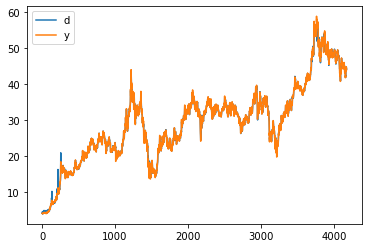

In [55]:
import matplotlib.pyplot as plt

a = []

for i in range(len(X_train)):
    test = loaded_model.predict([X_train[i]])
    a.append(test[0])
plt.plot(a, label='d')
plt.plot(y_train, label='y')
plt.legend()
plt.show()

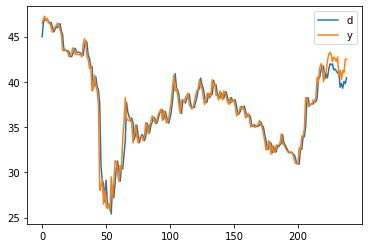

In [53]:
import matplotlib.pyplot as plt

a = []

for i in range(len(X_test)):
    test = loaded_model.predict([X_test[i]])
    a.append(test[0])
plt.plot(a, label='d')
plt.plot(y_test, label='y')
plt.legend()
plt.show()

In [52]:
# print(len(X_train))
counter = 0
for i in range(len(X_test)):
    test = loaded_model.predict([X_test[i]])
    if test[0] == y_test[i]:
        counter += 1
print(counter / len(X_test))

0.0


In [66]:
TPos = 0 # ทายว่าขึ้น และขึ้น
TNeg = 0 # ทายว่าลง และลง
FPos = 0 # ทายว่าลง แต่ขึ้น
FNeg = 0 # ทายว่าขึ้น แต่ลง

for i in range(1,len(X_test)):
    test = loaded_model.predict([X_test[i]])
    # TPos
    if (test[0] >= y_test[i-1]) and (y_test[i] >= y_test[i-1]):
        TPos += 1
    # TNeg
    if (test[0] <= y_test[i-1]) and (y_test[i] <= y_test[i-1]):
        TNeg += 1
    # FPos
    if (test[0] < y_test[i-1]) and (y_test[i] > y_test[i-1]):
        FPos += 1
    # FNeg
    if (test[0] > y_test[i-1]) and (y_test[i] < y_test[i-1]):
        FNeg += 1

print('TPos = ' + str(TPos/(len(X_test)-1))) 
print('TNeg = ' + str(TNeg/(len(X_test)-1))) 
print('TPos + TNeg = ' + str((TPos+TNeg)/(len(X_test)-1))) 
print()
print('FPos = ' + str(FPos/(len(X_test)-1))) 
print('FNeg = ' + str(FNeg/(len(X_test)-1))) 
print('FPos + FNeg = ' + str((FPos+FNeg)/(len(X_test)-1)))

TPos = 0.28991596638655465
TNeg = 0.33613445378151263
TPos + TNeg = 0.6260504201680672

FPos = 0.17647058823529413
FNeg = 0.19747899159663865
FPos + FNeg = 0.3739495798319328
